## Notebook to compare different models

Specifically compare PPO, DQN and A2C

In [16]:
#imports
import os
from stable_baselines3.common.callbacks import BaseCallback
from environment import LearningEnv     # your environment file
from gymnasium.envs.registration import register
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
import pandas as pd
import matplotlib.ticker as ticker

In [ ]:
#update global plt settings for nicer visualizations
plt.rcParams.update({
    "font.size": 14,          
    "axes.labelsize": 18,     
    "axes.titlesize": 20,     
    "legend.fontsize": 16,    
    "xtick.labelsize": 14,    
    "ytick.labelsize": 14,    
    "figure.figsize": (12, 8) 
})

## Train models

In [3]:
#set up folder structure to save results
BASE_DIR = "runs"
ALGOS = ["PPO", "A2C", "DQN"]
N_RUNS = 10
TIMESTEPS = 120_000

for algo in ALGOS:
    os.makedirs(os.path.join(BASE_DIR, algo), exist_ok=True)


In [4]:
#scheduler for entropy coefficient during training --> does not change functionality significantly but better for comparable visualization of results
class EntCoefScheduleCallback(BaseCallback):
    def __init__(self, initial_ent_coef, verbose=0):
        super().__init__(verbose)
        self.initial_ent_coef = initial_ent_coef

    def _on_step(self) -> bool:
        progress_remaining = 1 - self.num_timesteps / self.model._total_timesteps
        self.model.ent_coef = self.initial_ent_coef * progress_remaining
        return True

In [5]:
#function to create environment with specific seed
def make_env(seed: int):
    env = gym.make("MyEnv-v1")  
    env = Monitor(env)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

In [ ]:
#train and save models
for run_id in range(N_RUNS):
    seed = 10_0042 + run_id #arbitrary but fixed offset

    print(f"\n===== RUN {run_id} (seed={seed}) =====")

    # ---------- PPO ----------
    env = make_env(seed)
    ppo_callback = EntCoefScheduleCallback(initial_ent_coef=0.2) #only for visualization as otherwise it looks like it converges way lower

    model_ppo = PPO(
        policy="MlpPolicy",
        env=env,
        gamma=0.9,
        learning_rate=5e-05,
        n_steps=2048,
        clip_range=0.1,
        target_kl=0.01,
        ent_coef=0.2,
        verbose=0,
        seed=seed,
        tensorboard_log="./ppo_logs/"
    )

    model_ppo.learn(total_timesteps=TIMESTEPS, callback=ppo_callback)
    model_ppo.save(f"{BASE_DIR}/PPO/run_{run_id}/model")
    env.close()

    # ---------- A2C ----------
    env = make_env(seed)

    model_a2c = A2C(
        policy="MlpPolicy",
        env=env,
        gamma=0.9,
        ent_coef=0.05,
        verbose=0,
        seed=seed,
        tensorboard_log="./ppo_logs/"
    )

    model_a2c.learn(total_timesteps=TIMESTEPS)
    model_a2c.save(f"{BASE_DIR}/A2C/run_{run_id}/model")
    env.close()

    # ---------- DQN ----------
    env = make_env(seed)

    model_dqn = DQN(
        policy="MlpPolicy",
        env=env,
        learning_rate=5e-05,
        gamma=0.9,
        buffer_size=50_000,
        exploration_fraction=0.2,
        exploration_final_eps=0.02,
        batch_size=64,
        verbose=0,
        seed=seed,
        tensorboard_log="./ppo_logs/"
    )

    model_dqn.learn(total_timesteps=TIMESTEPS)
    model_dqn.save(f"{BASE_DIR}/DQN/run_{run_id}/model")
    env.close()

## Compare results

### Plot learning curves

In [ ]:
#function to load learning curves from csv files and aggregate them
def load_and_aggregate(algo_name, num_files=11):

    #load data
    data_frames = []
    #iterate over files
    for i in range(1, num_files + 1):
        df = pd.read_csv(f'visualizations/learning/{algo_name}_{i}.csv')
        #only need step and value columns
        series = df.set_index('Step')['Value']
        data_frames.append(series)
    
    #we need interpolation since time steps are offset between different alogirthms 
    #--> use linear interpolation

    #align all seeds into one DataFrame
    combined = pd.concat(data_frames, axis=1)
    
    #sort the index (timesteps) to ensure interpolation works correctly
    combined = combined.sort_index()
    
    #linearly interpolate
    #allows sem() to calculate values even if seeds didnt log at the exact same step
    combined = combined.interpolate(method='linear', limit_direction='both')
    
    mean = combined.mean(axis=1)
    std_err = combined.sem(axis=1)
    
    return mean.index, mean, std_err

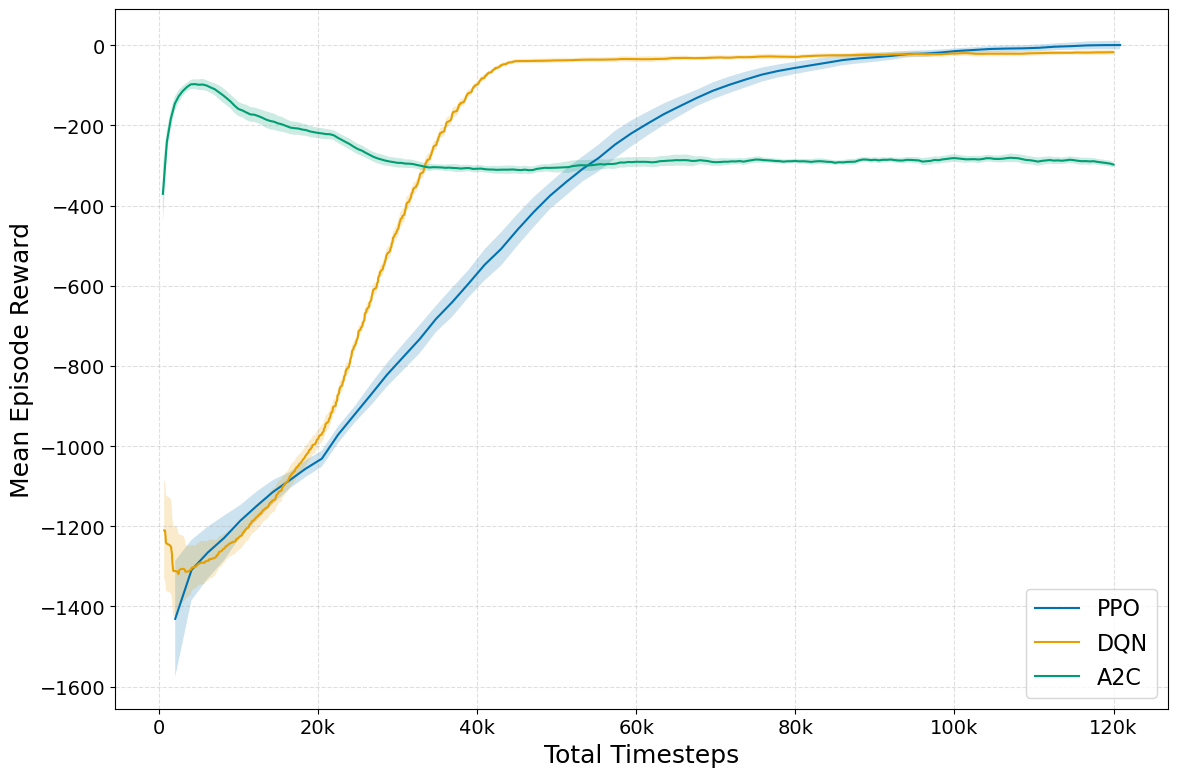

In [ ]:
#prepare data
algos = ["ppo", "dqn", "a2c"]
labels = ["PPO", "DQN", "A2C"]
#use color blind appropriate color palette
colors = ['#0072B2', '#E69F00', '#009E73']

fig, ax = plt.subplots()

#iterate over all algorithms and plot accordingl
for algo, label, color in zip(algos, labels, colors):

    #load
    steps, mean_vals, error = load_and_aggregate(algo)
    
    #plot mean line
    ax.plot(steps, mean_vals, color=color, label=label, linewidth=1.5, alpha=1.0)
    
    #plot the confidence interval
    ax.fill_between(steps, 
                    mean_vals - 1.96 * error, 
                    mean_vals + 1.96 * error, 
                    color=color, alpha=0.2, edgecolor='none')

#set labels
ax.set_xlabel('Total Timesteps')
ax.set_ylabel('Mean Episode Reward')
#ax.set_title('Learning Performance Comparison (Mean ± 95% CI)')

#function to format the time steps
def format_k(x, pos):
    if x >= 1e3: return f'{int(x/1000)}k'
    return f'{int(x)}'

#set correct tick labels 
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_k))

#add legend
ax.legend(loc='lower right', frameon=True, shadow=False)
#add grid
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig('rl_comparison_ci.png', dpi=300)
plt.show()